`Adapted from ng-video-lecture by Andrej Karpathy`

`Original source: https://github.com/karpathy/ng-video-lecture`

`Simplified and modified for clarity and educational use`

In [10]:
import sys
print(sys.executable)

/Users/dipanjansanyal/Documents/llm-fundamentals/llm-fundamentals/env/bin/python


In [11]:
# Experiment Configuration
context_length = 64
embed_dim = 128
heads = 4
layers = 3
batch_size = 32
num_iters = 3000
learning_rate = 0.00003
response_tokens = 50

In [12]:
import os
from tqdm import trange
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tokenmonster
import torch
import torch.nn as nn
torch.manual_seed(123)

In [13]:
# Check if MPS is available and use it if available (Mac)
# Otherwise check if GPU is available and use it if available
# Else use CPU

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


### Data and Tokenization

I downloaded a tiny CEFR data and worked on a it. Recommended to try on better datasets.

Note that, the batching here is a bit different than traidional epoch vs batch scenario when using `DataLoader()` because here we are not necessarily forming epochs. 1 epoch is supposed to be a full pass of the data and that happens through pre-configured batching iterator `DataLoader()`. Under each epoch, we pass a batch which is called an iteration. However, for that, we have to form a 2D tensor which will be heavy for large dataset.

Here we are directly forming the iteration without ensuring a full pass of the whole dataset. This is done in order to save memory space by not loading a huge 2D tensor. We can run the model upto desired number of steps by directly forming that many batches.

Also, in this case, I loaded the full text into `texts` but that can also be optimized by directly pulling batch from a saved text file.

In [14]:
# Reading the dataset
dataset = pd.read_csv("./data/cefr_leveled_texts.csv", index_col=0)
dataset = dataset.query('label == "A1"').reset_index() # Selecting easiest level
# Deduplicate repeated headlines
dataset = dataset.filter(['text']).drop_duplicates()
print("Dataset shape:", dataset.shape)
print("Dataset columns:", dataset.columns)

# Excluding short texts
paragraphs = dataset['text'].tolist()
paragraphs = [p for p in paragraphs if len(p) > 10]

# Streaming the data
texts = '<|endoftext|>'.join(paragraphs)

Dataset shape: (288, 1)
Dataset columns: Index(['text'], dtype='object')


In order to ensure a tiny model, I used tiny tokenizer from `tokenmonster` but a more standard tokenizer like GPT tokenizer could also be chosen. Smaller tokenizers have smaller word-pieces as tokens, so even forming a meaningful word with them is quite a task for the model. In case of GPT tokenizer, the model size would increase but it won't struggle to form words. 

In [15]:
# Loading pre-trained tokenizer (a very small one so that model doesn't become too big)
# Adding special end of document token using which we shall be streaming the data
tokenizer = tokenmonster.load("english-2048-consistent-v1")
tokenizer.add_special_token('<|endoftext|>')

# Tokenizing
tokens = tokenizer.tokenize(texts)

In [16]:
# Batching with train/test split

def get_batch(mode, train_ratio):
    
    train_test_cutover_token = int(len(tokens) * train_ratio)

    seq = np.empty((batch_size, context_length), dtype=np.int64)
    for i in range(batch_size):
        if mode == 'train':
            start = np.random.randint(0, train_test_cutover_token - context_length)
        elif mode == 'test':
            start = np.random.randint(train_test_cutover_token, len(tokens) - context_length)
        else:
            raise ValueError("mode must be 'train' or 'test'")
        
        seq[i] = tokens[start : start + context_length]
    
    xb = torch.tensor(seq[:,:-1], dtype=torch.long).to(device)
    yb = torch.tensor(seq[:,1:], dtype=torch.long).to(device)

    return xb, yb

### Model Building

In [17]:
# Borrowing the FeedForward and Block classes from Part 2 notebook + dropout and layer norm
# We shall be using in-built MultiHeadAttention class from PyTorch

class FeedFoward(nn.Module):

    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, 4 * C),
            nn.ReLU(),
            nn.Linear(4 * C, C),
            nn.Dropout(0.2)
        )

    def forward(self, mh_out):
        ff_out = self.net(mh_out)
        return ff_out

class Block(nn.Module):

    def __init__(self, C, num_heads, T):
        super().__init__()
        
        hs = C // num_heads # because in the end the heads will be concatenated to C
        self.multihead = nn.MultiheadAttention(C, num_heads, dropout=0.2, batch_first=True)
        self.ff = FeedFoward(C)
        self.ln1 = nn.LayerNorm(C)
        self.ln2 = nn.LayerNorm(C)
        self.proj_q = nn.Linear(C, C)
        self.proj_k = nn.Linear(C, C)
        self.proj_v = nn.Linear(C, C)
        self.register_buffer('attn_mask', nn.Transformer.generate_square_subsequent_mask(T-1))

    def forward(self, x_embed):
        
        B, t, C = x_embed.size()
        x_embed_norm = self.ln1(x_embed)
        q = self.proj_q(x_embed_norm)
        k = self.proj_k(x_embed_norm)
        v = self.proj_v(x_embed_norm)
        attn = self.attn_mask[:t, :t].to(device)
        mh_out, _ = self.multihead(q, k, v, is_causal=True, attn_mask=attn)
        mh_out = x_embed_norm + mh_out
        mh_out_norm = self.ln2(mh_out)
        block_out = mh_out_norm + self.ff(mh_out_norm)
        return block_out


In [18]:
# Borrowing the language model class from Part 2 notebook with a few changes

class GPTLanguageModel(nn.Module):
    
    def __init__(self, V, T, C, num_heads, n_layer):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(V, C)
        self.position_embedding_table = nn.Embedding(T-1, C)
        self.blocks = nn.Sequential(*[Block(C, num_heads, T) for _ in range(n_layer)])
        self.lm_head = nn.Linear(C, V)

    def forward(self, idx, targets=None):
        B, t = idx.shape
        x_tok_embed = self.token_embedding_table(idx)
        x_pos_embed = self.position_embedding_table(torch.arange(t, device=idx.device))
        x_embed = x_tok_embed + x_pos_embed
        x_t_out = self.blocks(x_embed)
        x_logits = self.lm_head(x_t_out)

        if targets is None:
            loss = None
        else:
            B, t, C = x_logits.shape
            logits = x_logits.view(B*t, C)
            targets = targets.view(B*t)
            loss = nn.functional.cross_entropy(logits, targets)

        return x_logits, loss


### Model class I/O testing

In [19]:
# Call instance of our model class
model = GPTLanguageModel(V=tokenizer.vocab_size, T=context_length, C=embed_dim, num_heads=heads, n_layer=layers)
model = model.to(device)

# Calling a batch of data
xb, yb = get_batch('train', 0.8)

# Pass predictor sequence through the model
x_logits, loss = model(idx = xb, targets = yb)

print(x_logits.shape)
print(loss)


torch.Size([32, 63, 2049])
tensor(7.8085, device='mps:0', grad_fn=<NllLossBackward0>)


### Training the model

In [20]:
# Call instance of model class
m = GPTLanguageModel(V=tokenizer.vocab_size, T=context_length, C=embed_dim, num_heads=heads, n_layer=layers)
m.to(device)

# Define optimizer
optim = torch.optim.AdamW(m.parameters(), lr=learning_rate)

# Training loop
batch_train_loss = []
batch_test_loss = []

for i in trange(num_iters, desc="Iterations"):    

    m.train()
    Xb, yb = get_batch('train', 0.9)        

    # forward pass and loss
    _, loss = m.forward(Xb, yb)        

    # backprop
    optim.zero_grad()
    loss.backward()
    optim.step()

    # print("Trained for epoch {}".format(epochi))        
    batch_train_loss.append(loss.item())   

    m.eval()
    with torch.no_grad():
        Xb, yb = get_batch('test', 0.9)           

        # forward pass and loss
        _, loss = m.forward(Xb, yb)        

        batch_test_loss.append(loss.item())    

        # print("Eval for epoch {}".format(epochi))    

    # Clear cache in case of GPU
    if device == torch.device("cuda"):
        torch.cuda.empty_cache()

Iterations: 100%|██████████| 3000/3000 [01:34<00:00, 31.82it/s]


<Axes: title={'center': 'Training and Test Loss'}, xlabel='Iterations', ylabel='Loss'>

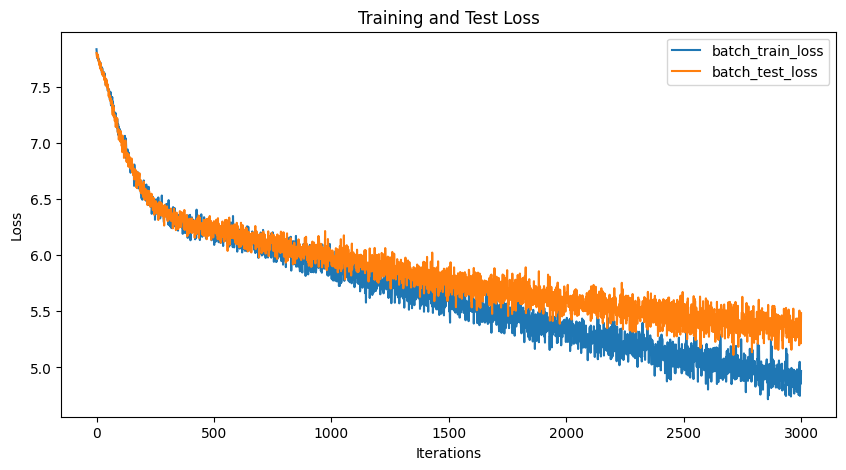

In [21]:
# Plot to see drop in test loss

losses = pd.DataFrame(
    {'batch_train_loss':batch_train_loss, 
     'batch_test_loss':batch_test_loss}
)

losses.plot(kind='line', figsize=(10, 5), xlabel='Iterations', ylabel='Loss', title='Training and Test Loss')


In [22]:
# Save the model
torch.save(m.state_dict(), './model/gpt_model.pth')

### Generation

In [23]:
# Recreate the model architecture
loaded_model = GPTLanguageModel(
    V=tokenizer.vocab_size, 
    T=context_length, 
    C=embed_dim, 
    num_heads=heads, 
    n_layer=layers
)
loaded_model = loaded_model.to(device)

# Load the saved weights
loaded_model.load_state_dict(torch.load('./model/gpt_model.pth', map_location=device))

<All keys matched successfully>

In [25]:
# user input
queries = [
    "Going to school is fun and", 
    "I really like pizza as much as I like holidays because"
]
temperature = 0.3


import warnings
warnings.filterwarnings('ignore')


# Text completion loop
for q in queries:

    print("------------------------")
    print("Here is the given sequence:\n", q)

    qt = tokenizer.tokenize(q)
    qt = torch.from_numpy(qt).long()
    result = qt.unsqueeze(0).to(device)

    
    for i in range(response_tokens):
        new_inputs = result[:, -(context_length-1):]
        m.eval()
        with torch.no_grad():
            x_logits, _ = loaded_model(idx=new_inputs, targets=None)
        
        # Get logits for the last token
        next_token_logits = x_logits[:, -1, :]  # shape: (1, vocab_size)
        # Apply temperature
        next_token_logits = next_token_logits / temperature
        # Convert logits to probabilities
        probs = torch.softmax(next_token_logits, dim=-1)
        # Sample from the distribution
        predicted_next_token = torch.multinomial(probs, num_samples=1)
        result = torch.cat((result, predicted_next_token), dim=1)

    print("\nHere is the generated sequence:\n", tokenizer.decoder().decode(result.squeeze(0).tolist()))

------------------------
Here is the given sequence:
 Going to school is fun and

Here is the generated sequence:
 Going to school is fun and This. He wanted to see the lilow, but she looked at the. She thought. He didn't sair. The trash. She toldt. She looked at the. She turned her mom. She told her no. She
------------------------
Here is the given sequence:
 I really like pizza as much as I like holidays because

Here is the generated sequence:
 I really like pizza as much as I like holidays because the cat. He wanted to. He went was. He put the whed. He went to the picked the man the man. He looked at the. He wented the dby. He asked. He could he took the t
